# Шаг 1. Подготовка данных

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,12)

from ipywidgets import interact, IntSlider, FloatSlider

In [130]:
df_sample = pd.read_csv('sample_submission.csv')
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df_train.loc[:, 'sample'] = 'train'
df_test.loc[:, 'sample'] = 'test'
df = df_test.append(df_train).reset_index(drop=True)

# df.info()

In [131]:
object_dict = []
for i in df.columns: # перебираем все столбцы
    if (str(df[i].dtype) == 'object') and (i != '_id') and (i != 'sample') : # если тип столбца - object
        print('='*10)
        print(i) # выводим название столбца
        print(set(df[i])) # выводим все его значения (но делаем set - чтоб значения не повторялись)
        print('\n') # выводим пустую строку
        object_dict.append(i)

contact
{'cellular', 'telephone'}


day_of_week
{'wed', 'mon', 'fri', 'thu', 'tue'}


default
{'no', 'yes', 'unknown'}


education
{'high.school', 'basic.9y', 'university.degree', 'basic.4y', 'unknown', 'professional.course', 'illiterate', 'basic.6y'}


housing
{'no', 'yes', 'unknown'}


job
{'self-employed', 'admin.', 'services', 'management', 'student', 'technician', 'unknown', 'unemployed', 'housemaid', 'retired', 'entrepreneur', 'blue-collar'}


loan
{'no', 'yes', 'unknown'}


marital
{'divorced', 'married', 'single', 'unknown'}


month
{'oct', 'nov', 'sep', 'mar', 'aug', 'may', 'dec', 'apr', 'jul', 'jun'}


poutcome
{'nonexistent', 'failure', 'success'}




In [132]:
def preproc_data(df_input):
    df_output = df_input.copy()
    
    df_output = df_output.drop('_id', axis = 1)

    df_output = pd.get_dummies(df_output, columns=object_dict)
    
    return df_output

In [133]:
df = preproc_data(df)
# df.info()

In [134]:
# df.describe().T

In [135]:
df_preproc = df

df_train_preproc = df_preproc.query('sample == "train"').drop(['sample'], axis=1)
df_test_preproc = df_preproc.query('sample == "test"').drop(['sample'], axis=1)

In [136]:
df_y_train = list(df_train_preproc['target'])
df_x_train = df_train_preproc.drop(['target'], axis = 1)
df_y_test = list(df_test_preproc['target']) # здесь неизвестные значения Nan - которые нужно найти
df_x_test = df_test_preproc.drop(['target'], axis = 1) # здесь входные параметры
print('X train ', df_x_train.shape)
print('Y train ', len(df_y_train))
print('X test ',df_x_test.shape)
print('Y test ', len(df_y_train))

X train  (24712, 63)
Y train  24712
X test  (16476, 63)
Y test  24712


# Шаг 2. Проверка 3-х моделей на df_x_train (X_train, X_test) и df_y_train (y_train, y)

In [137]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression  # импортируем модель машинного обучения
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve

X_train, X_test, y_train, y = train_test_split(df_x_train, df_y_train, test_size=0.33, random_state=42)
print('X_train ', X_train.shape)
print('X_test ',X_test.shape)

X_train  (16557, 63)
X_test  (8155, 63)


In [138]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split

dict_model = {}

model1 = KNeighborsClassifier(n_neighbors=3, weights='uniform', metric='euclidean')
model1.fit(X_train, y_train)

predict = model1.predict(X_test)                      # делаем предсказание
dict_model ['KNeighborsClassifier']= [precision_score(y, predict), recall_score(y, predict), accuracy_score(y, predict)]
print('#'*10,'>>> KNeighborsClassifier <<<','#'*10,'\n',classification_report(y, predict),'\n')

########## >>> KNeighborsClassifier <<< ########## 
              precision    recall  f1-score   support

        0.0       0.93      0.95      0.94      7230
        1.0       0.56      0.47      0.52       925

avg / total       0.89      0.90      0.89      8155
 



Text(0,0.5,'ROC AUC')

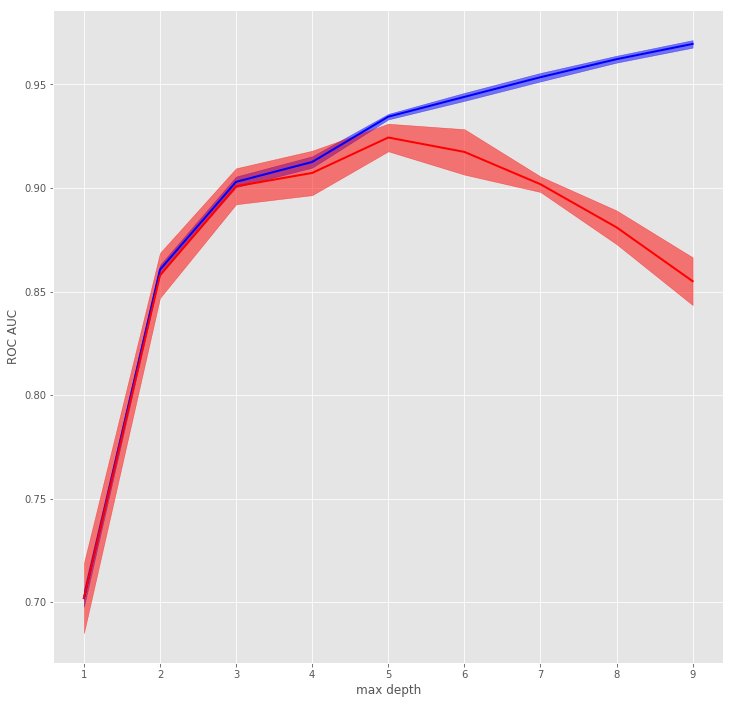

In [139]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from ipywidgets import interact, IntSlider
import subprocess

try:
    from sklearn.model_selection import validation_curve
except ImportError:
    from sklearn.learning_curve import validation_curve

try:
    from sklearn.model_selection import StratifiedKFold
except ImportError:
    from sklearn.cross_validation import StratifiedKFold

# ---------------------------------------------------------------------
# ищем максимальную точность на графике max_depth

model2 = DecisionTreeClassifier(random_state=123)
model2.fit(X_train, y_train)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=132)
train_scores, valid_scores = validation_curve(model2, X_train, y_train, 
                                              'max_depth', range(1, 10),
                                              cv=cv, scoring='roc_auc')
train_score_mean = train_scores.mean(axis=1)
train_score_std = train_scores.std(axis=1)
valid_scores_mean = valid_scores.mean(axis=1)
valid_scores_std = valid_scores.std(axis=1)

plt.fill_between(range(1,10), train_score_mean-train_score_std, train_score_mean+train_score_std, color='b',
                 interpolate=True, alpha=0.5,)
plt.fill_between(range(1,10), valid_scores_mean-valid_scores_std, valid_scores_mean+valid_scores_std, color='r', 
                 interpolate=True, alpha=0.5)

plt.plot(range(1,10), train_score_mean, c='b', lw=2) #синяя линия обучающая выборка
plt.plot(range(1,10), valid_scores_mean, c='r', lw=2) #красная линяя - валидационная выборка

plt.xlabel('max depth')
plt.ylabel('ROC AUC')

# это значит, что мы будем проверять влияние параметра max_depth
# в дапозоне от 1 до 10
# и для этого мы будем использовать 5-fold кросс-валидацию
# с мерой качества mean_absolute_error.
# neg_ потому что по умолчанию в sklearn чем значение меры выше - тем лучше, 
# но в нашем случае нам нужно как раз допускать меньшую ошибку
# ---------------------------------------------------------------------

In [140]:
depth=5 #видно из графика

model2 = DecisionTreeClassifier(max_depth = depth, random_state=123)
model2.fit(X_train, y_train)

predict = model2.predict(X_test)                      # делаем предсказание
dict_model ['DecisionTreeClassifier']= [precision_score(y, predict), recall_score(y, predict), accuracy_score(y, predict)]
print('#'*10,'>>> DecisionTreeClassifier <<<','#'*10,'\n',classification_report(y, predict),'\n')

########## >>> DecisionTreeClassifier <<< ########## 
              precision    recall  f1-score   support

        0.0       0.94      0.97      0.95      7230
        1.0       0.68      0.49      0.57       925

avg / total       0.91      0.92      0.91      8155
 



In [141]:
model3 = LogisticRegression()                     # инициализируем модель
model3.fit(X_train, y_train)                      # обучаем модель
predict = model3.predict(X_test)                      # делаем предсказание
dict_model ['LogisticRegression']= [precision_score(y, predict), recall_score(y, predict), accuracy_score(y, predict)]
print('#'*10,'>>> LogisticRegression <<<','#'*10,'\n',classification_report(y, predict),'\n')

########## >>> LogisticRegression <<< ########## 
              precision    recall  f1-score   support

        0.0       0.93      0.97      0.95      7230
        1.0       0.68      0.41      0.51       925

avg / total       0.90      0.91      0.90      8155
 



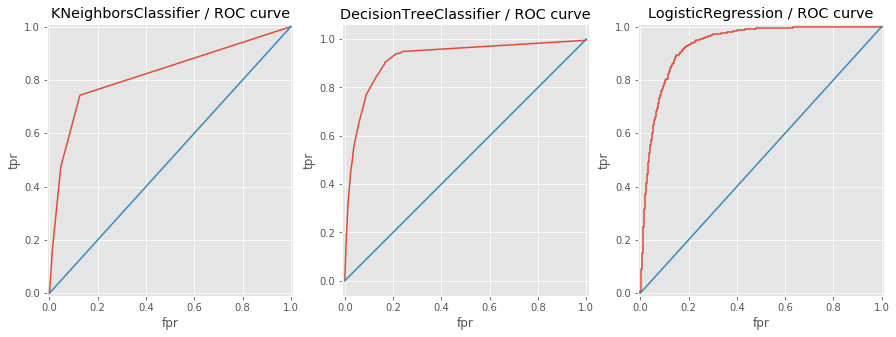

In [142]:
# Потроить roc-кривые всех можелей на одном графике
# Вывести roc_auc каждой моделе
# Подпишите оси и линии

plt.figure(figsize=(15, 5))

#subplot 1
plt.subplot(131)
predict_proba1 = model1.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y, predict_proba1[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('KNeighborsClassifier / ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))
#subplot 2
plt.subplot(132)
predict_proba2 = model2.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y, predict_proba2[:,1])
plt.plot(fpr, tpr);
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.axis('equal')
plt.grid(True)
plt.title('DecisionTreeClassifier / ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))
#subplot 3
plt.subplot(133)
predict_proba3 = model3.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y, predict_proba3[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('LogisticRegression / ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))
plt.show()

In [143]:
from sklearn.cross_validation import cross_val_score
# Сделать k-fold (10 фолдов) кросс-валидацию каждой модели
# И посчитать средний roc_auc

cross1 = cross_val_score(model1,df_x_train,df_y_train,scoring='roc_auc', cv=10)
cross2 = cross_val_score(model2,df_x_train,df_y_train,scoring='roc_auc', cv=10)
cross3 = cross_val_score(model3,df_x_train,df_y_train,scoring='roc_auc', cv=10)
print('#'*10,'>>> AVG roc_auc for Train: <<<','#'*10,'\nModel 1. KNeighborsClassifier\t{:.2f}\nModel 2. DecisionTreeClassifier\t{:.2f}\nModel 3. LogisticRegression\t{:.2f} '
      .format( (sum(cross1) / float(len(cross1))),(sum(cross2) / float(len(cross2))),(sum(cross3) / float(len(cross3))) ) )

########## >>> AVG roc_auc for Train: <<< ########## 
Model 1. KNeighborsClassifier	0.83
Model 2. DecisionTreeClassifier	0.93
Model 3. LogisticRegression	0.93 


#  Шаг 3. По лучшей модели ищем решение df_y_test по df_x_test

In [144]:
predict = model2.predict(df_x_test)
df_test['target'] = predict
df_test['target'] = df_test['target'].astype('int')
print(list(df_test.columns))

['_id', 'age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'sample', 'target']


In [145]:
# df_train.head().T

In [146]:
df_result = df_test.drop(['age', 'job', 'marital', 'education', 'default', 'housing',
                          'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign',
                          'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
                          'cons.conf.idx', 'euribor3m', 'nr.employed', 'sample'], axis = 1)
# df_result.head()

In [147]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16476 entries, 0 to 16475
Data columns (total 2 columns):
_id       16476 non-null object
target    16476 non-null int32
dtypes: int32(1), object(1)
memory usage: 193.2+ KB


In [148]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16476 entries, 0 to 16475
Data columns (total 2 columns):
_id       16476 non-null object
target    16476 non-null int64
dtypes: int64(1), object(1)
memory usage: 257.5+ KB


# Шаг 4. Запись результатов в файл 'result_submission.csv'

In [149]:
df_result.to_csv('result_submission.csv', sep=',', encoding='utf-8',index=False)